# Compare DBTL2 and DBTL3

In DBTL3, David remade the strains from DBTL2 with a different dCas9 system, which should increase dCas9 expression. 

In this notebook, we want to compare results between runs

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

In [2]:
user_params = {
    'output_dir'  : './',
    'protein_map' : '../DBTL0_data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
}

## Import raw DBTL3 data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [3]:
study_slug_1 = 'crispri-automation-for-enhanced-isoprenol-pro-a97b'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'

We try connecting to the server with our login and password:

In [35]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [5]:
# df = pd.read_csv('./dbtl2_full_data.csv')
try:
    df_dbtl3_raw = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

  0%|          | 0/411567 [00:00<?, ?it/s]

## Import raw DBTL2 data

In [6]:
df_dbtl2_raw = pd.read_csv('../dbtl2_full_data.csv')
# try:
#     df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
# except (NameError, AttributeError, KeyError):
#     print(f'ERROR! Not able to export the study.')

## Import DBTL2 and 3 processed data
These notebooks come from the notebooks DBTL2/3_A_analyze_proteomics.ipynb. They include the dCas9 measurements, target measurements for each target in a strain, and the normalized measurement to control.

In [7]:
df_dbtl2 = pd.read_csv('./dbtl2_df_target.csv', index_col=0)
df_dbtl3 = pd.read_csv('./dbtl3_df_target.csv', index_col=0)

In [8]:
df_dbtl2.head(3)

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,above_dcas9_thresh,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,target_4_belowthresh,all_targets_belowthresh,all_reps_belowthresh,all_reps_above_dcas9_thresh,to_keep,to_keep_improved
0,PP_0528_PP_0815_PP_1317_PP_4191-R1,1,False,PP_0528_PP_0815_PP_1317_PP_4191,4,201.9179,49382.666,0.013451,PP_0528,PP_0815,...,False,False,True,False,False,False,False,False,False,False
1,PP_0528_PP_0813_PP_0815_PP_1317-R1,1,False,PP_0528_PP_0813_PP_0815_PP_1317,4,392.7469,4455954.600,1.213698,PP_0528,PP_0813,...,True,True,False,True,False,False,False,True,True,False
2,PP_0528_PP_0814_PP_0815_PP_1317-R1,1,False,PP_0528_PP_0814_PP_0815_PP_1317,4,457.0174,3443301.800,0.937875,PP_0528,PP_0814,...,True,True,False,True,False,False,False,True,True,False


In [9]:
df_dbtl3.head(3)

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,above_dcas9_thresh,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,target_4_belowthresh,all_targets_belowthresh,all_reps_belowthresh,all_reps_above_dcas9_thresh,to_keep,to_keep_improved
0,Control_P1-R1,1,True,Control,0,164.5141,5359855.90,1.288020,NaN,NaN,...,True,False,False,False,False,True,True,True,True,True
1,Control_P1-R2,2,True,Control,0,164.3461,4366543.06,1.049318,NaN,NaN,...,True,False,False,False,False,True,True,True,True,True
2,Control_P1-R3,3,True,Control,0,182.1113,5468736.89,1.314185,NaN,NaN,...,True,False,False,False,False,True,True,True,True,True


### Merge processed dataframes

In [10]:
df_dbtl2['cycle'] = 2
df_dbtl3['cycle'] = 3
df_merge = pd.concat([df_dbtl2, df_dbtl3])

In [11]:
df_merge.shape[0] == df_dbtl2.shape[0] + df_dbtl3.shape[0]

True

### Drop non-matching lines between runs:

In [12]:
shared_lines = list(
    set(df_dbtl2['line_name_norep'].unique()).intersection(
        set(df_dbtl3['line_name_norep'].unique())
    )
)
print(f"There are N = {len(df_dbtl2['line_name_norep'].unique())} unique lines in dbtl2, N = {len(df_dbtl3['line_name_norep'].unique())} unique lines in dbtl3, and N = {len(shared_lines)} shared lines.")
df_merge = df_merge.loc[df_merge['line_name_norep'].isin(shared_lines), :]

There are N = 60 unique lines in dbtl2, N = 57 unique lines in dbtl3, and N = 50 shared lines.


## Plot some single strains
Look at how target downregulation compares for strains between runs

Iterate through the first 6 unique lines, create a dataframe of only those lines for each cycle, melt the dataframe to format it for `sns.barplot()`, and add a plot to the figure.

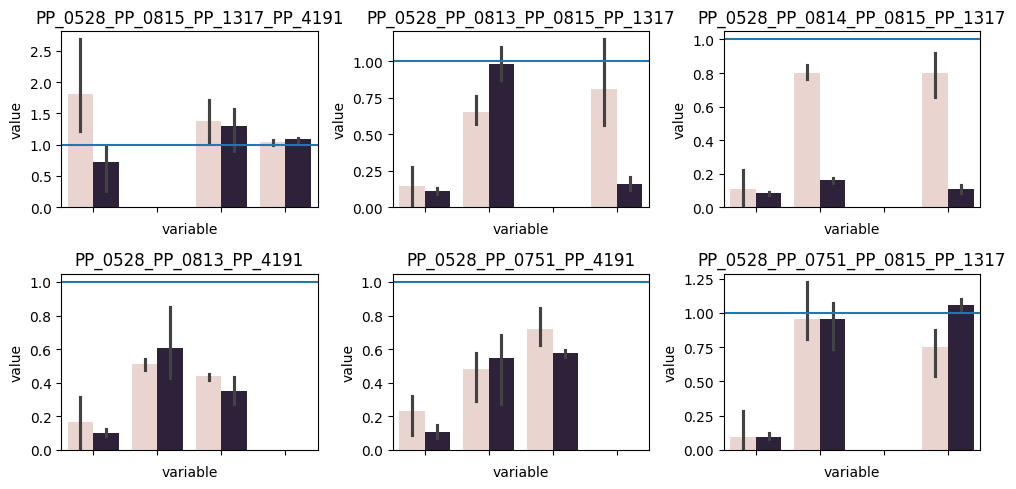

In [13]:
unique_line_names = df_merge['line_name_norep'].unique()
col_to_keep = ['line_name_norep', 'target_1_norm', 'target_2_norm', 'target_3_norm', 'target_4_norm', 'cycle']
fig, ax = plt.subplots(2,3, figsize = (10,5))
for i, ln in enumerate(unique_line_names[:6]):
    a = fig.get_axes()[i]
    df_melt = df_merge.loc[df_merge['line_name_norep'] == ln, col_to_keep].melt(id_vars = ['line_name_norep', 'cycle'])
    sns.barplot(data = df_melt, x = 'variable', y = 'value', hue = 'cycle', ax = a)
    a.set_xticklabels([])
    a.legend().remove()
    a.axhline(1)
    a.set_title(ln)
    
fig.tight_layout()

## Scatter plot of relative target downregulation for each strain
Get the mean value of each target for each line and format to plot with `sns.scatterplot()`. 

In [14]:
cycle2_norm = df_merge.loc[
    df_merge['cycle'] == 2, ['line_name_norep','target_1_norm', 'target_2_norm', 'target_3_norm', 'target_4_norm']
].melt(id_vars = 'line_name_norep').rename(columns = {'value':'cycle2_value'})
#Get the number of the target and add it to the linename variable
cycle2_norm['linename_target'] = cycle2_norm.apply(lambda x: f'{x["line_name_norep"]}_t{x["variable"].split("_")[1]}', axis = 1)
#Get mean value for each linename/target across reps
cycle2_norm = cycle2_norm.loc[:,['linename_target', 'cycle2_value']].groupby(by = 'linename_target').mean()


cycle3_norm = df_merge.loc[
    df_merge['cycle'] == 3, ['line_name_norep','target_1_norm', 'target_2_norm', 'target_3_norm', 'target_4_norm']
].melt(id_vars = 'line_name_norep').rename(columns = {'value':'cycle3_value'})
cycle3_norm['linename_target'] = cycle3_norm.apply(lambda x: f'{x["line_name_norep"]}_t{x["variable"].split("_")[1]}', axis = 1)
cycle3_norm = cycle3_norm.loc[:,['linename_target', 'cycle3_value']].groupby(by = 'linename_target').mean()

### Join dataframes between cycles
Do an inner join between `cycle2_norm` and `cycle3_norm` to get the cycle2 and cycle3 value for each strain/target.

Note there will be some NaN value depending on whether the target exists.

In [15]:
target_expression_df = cycle2_norm.loc[:,['cycle2_value']].merge(cycle3_norm.loc[:,['cycle3_value']],
                                                                              how = 'inner', on = 'linename_target')
target_expression_df.tail(5)

,cycle2_value,cycle3_value
linename_target,,
PP_2136_PP_4189_t4,NaN,NaN
PP_4189_PP_4192_t1,0.244529,0.371738
PP_4189_PP_4192_t2,0.388348,0.352108
PP_4189_PP_4192_t3,NaN,NaN
PP_4189_PP_4192_t4,NaN,NaN


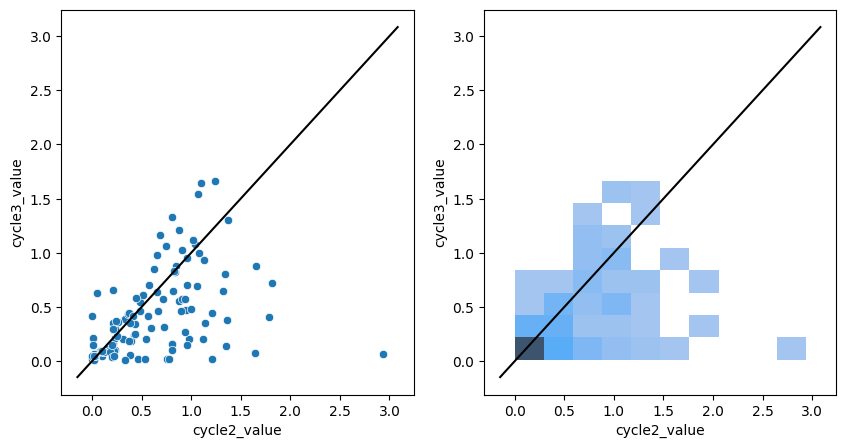

In [16]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.scatterplot(data = target_expression_df, x = 'cycle2_value', y = 'cycle3_value', ax = ax[0])
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x,x, 'k')
sns.histplot(data = target_expression_df, x = 'cycle2_value', y = 'cycle3_value', ax = ax[1])
ax[1].plot(x,x, 'k')


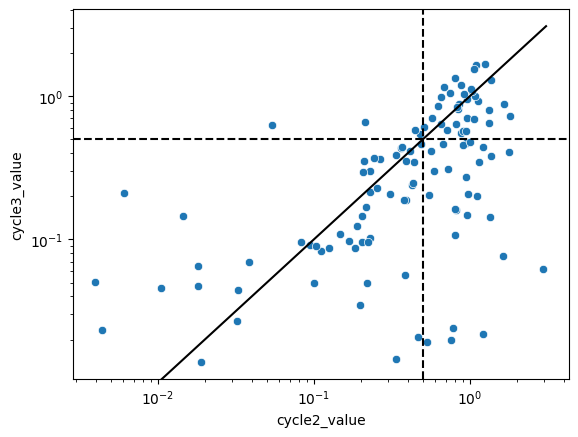

In [17]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(data = target_expression_df, x = 'cycle2_value', y = 'cycle3_value', ax = ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x,x, 'k')
ax.axhline(0.5, c='k', linestyle = '--')
ax.axvline(0.5, c='k', linestyle = '--')
ax.set_xscale('log')
ax.set_yscale('log')


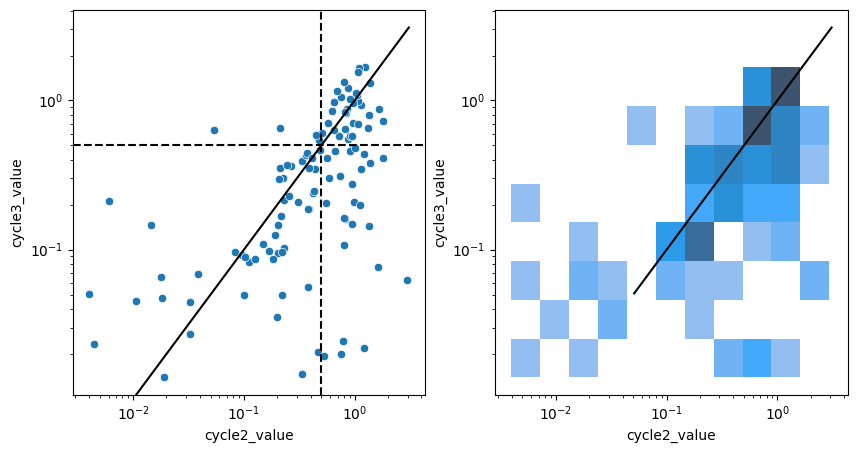

In [18]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.scatterplot(data = target_expression_df, x = 'cycle2_value', y = 'cycle3_value', ax = ax[0])
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x,x, 'k')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].axhline(0.5, c='k', linestyle = '--')
ax[0].axvline(0.5, c='k', linestyle = '--')
sns.histplot(data = target_expression_df[target_expression_df['cycle2_value']>0], x = 'cycle2_value', y = 'cycle3_value', ax = ax[1], log_scale=True)
ax[1].plot(x,x, 'k')


Do some stats for the linear relationship b/w cycle2_value and cycle3_value

In [19]:
from scipy.stats import spearmanr

In [20]:
target_expression_df

,cycle2_value,cycle3_value
linename_target,,
Control_t1,NaN,NaN
Control_t2,NaN,NaN
Control_t3,NaN,NaN
Control_t4,NaN,NaN
PP_0368_PP_0528_PP_4191_t1,0.100558,0.049960
...,...,...
PP_2136_PP_4189_t4,NaN,NaN
PP_4189_PP_4192_t1,0.244529,0.371738
PP_4189_PP_4192_t2,0.388348,0.352108


In [21]:
both_nonzero = (target_expression_df['cycle2_value']>0 ) & (target_expression_df['cycle3_value']>0)
res = spearmanr(
    target_expression_df.loc[both_nonzero, 'cycle2_value'], 
    target_expression_df.loc[both_nonzero, 'cycle3_value']
)
print(f'Spearman rho: {res.statistic:.3f}\t log10(p) = {np.log10(res.pvalue):.3f}')

Spearman rho: 0.570	 log10(p) = -10.369


## Determine if target_specific inhibition changed from DBTL2 to DBTL3
We want to see if different targets behave different between cycles (i.e. "Did PP_0814 get more inhibited between cycle 2 and cycle 3?")

1) Make a dataframe with columns for the line name, the cycle, the gRNA position, the specific target, and the normalized target value.
2) Iterate through the lines in the merged target dataframe (i.e. Line 1, Line 2, Line 3...).
3) For each row in the target df, iterate through target columns (Line 1 Target 1, Line 1 target 2, line 1 target 3...).
4) Create a pandas df for that strain and target and add it to the cumulative dataframe.

In [22]:
target_downregulation_df = pd.DataFrame(columns = ['line_name_norep', 'cycle', 'position', 'target', 'expr_norm'])
target_cols = [f'target_{i}' for i in [1,2,3,4]]
target_val_cols = [f'target_{i}_norm' for i in [1,2,3,4]]
for index, row in df_merge.iterrows():
    for target_idx in range(row['number_of_grna']):
        new_row = pd.DataFrame(columns = target_downregulation_df.columns,
                               data = np.array(
                                   [row['line_name_norep'],
                                    row['cycle'],
                                    target_idx,
                                    row[target_cols[target_idx]],
                                    row[target_val_cols[target_idx]]
                                ]
                              ).reshape(1,-1)
                              )
        target_downregulation_df = pd.concat([target_downregulation_df, new_row])

Format dataframe - drop strains with NaN measurements, and set the type of numeric columns

In [23]:
target_downregulation_df = target_downregulation_df.reset_index(drop = True)
target_downregulation_df = target_downregulation_df.drop(
    target_downregulation_df.loc[
        target_downregulation_df['expr_norm'] == 'nan', :].index
).reset_index(drop = True)
target_downregulation_df['expr_norm'] = target_downregulation_df['expr_norm'].astype(float)
target_downregulation_df['cycle'] = target_downregulation_df['cycle'].astype(int)

Now we can plot:

<Axes: xlabel='expr_norm', ylabel='target'>

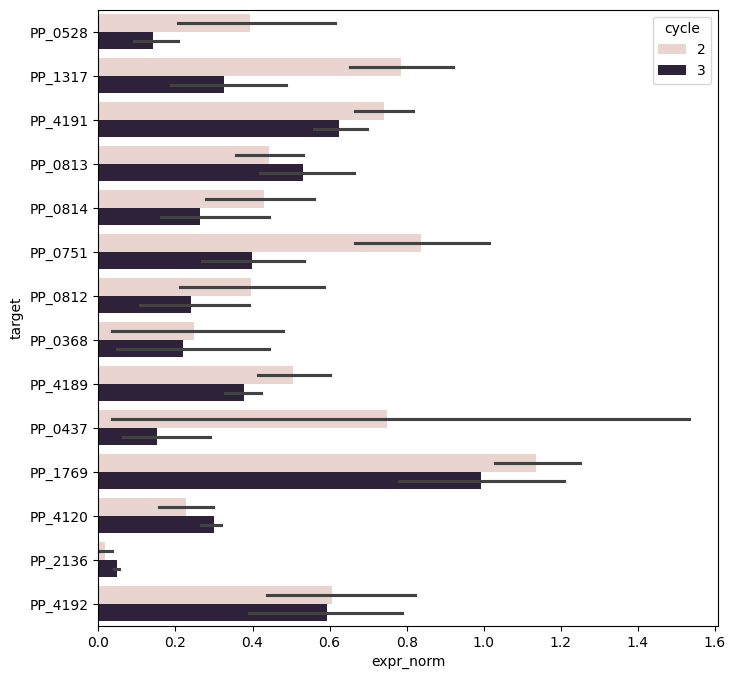

In [24]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
sns.barplot(data = target_downregulation_df, y = 'target', x = 'expr_norm', hue = 'cycle')

<Axes: xlabel='expr_norm', ylabel='target'>

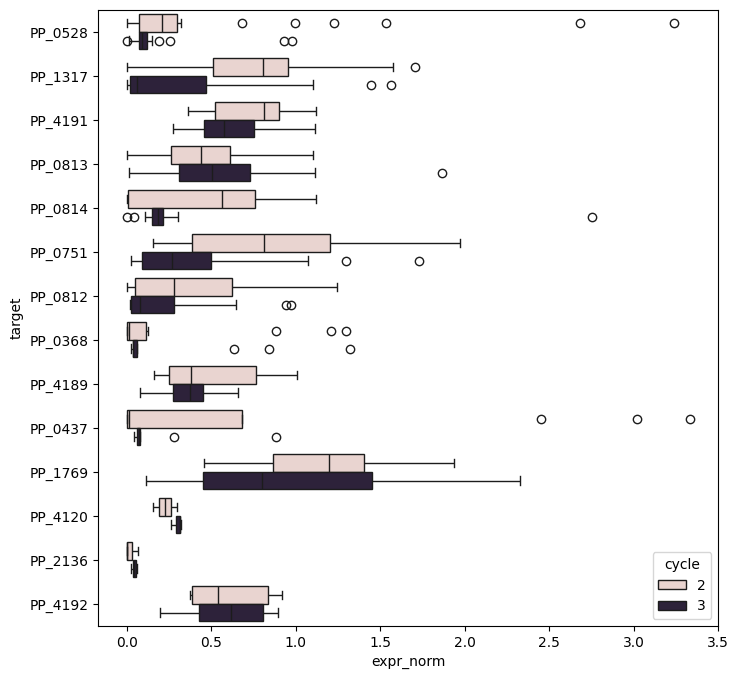

In [25]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
sns.boxplot(data = target_downregulation_df, y = 'target', x = 'expr_norm', hue = 'cycle')

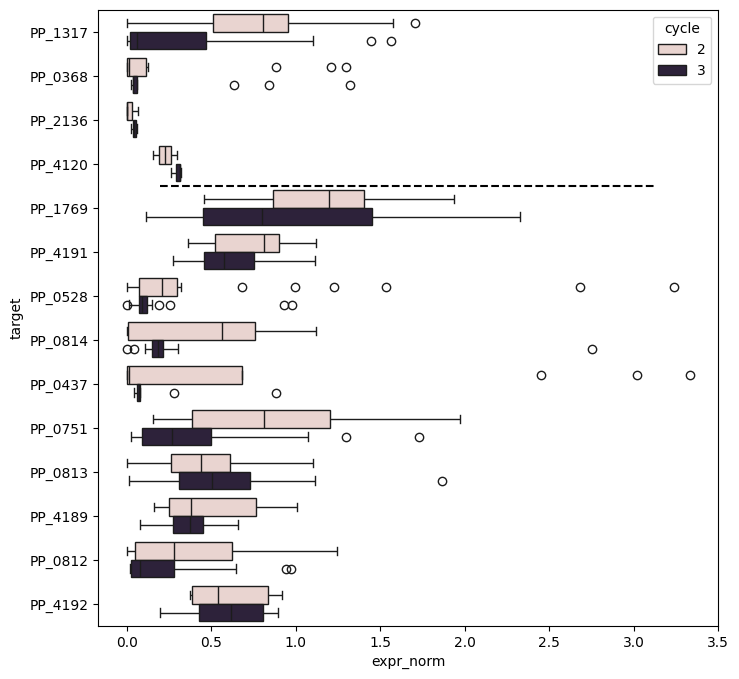

In [26]:
rbtnseq_essential_dict = {'PP_0812': True,
                          'PP_0813': True,
                          'PP_0814': True,
                          'PP_0815': True,
                          'PP_1317': False,
                          'PP_4191': True,                         
                          'PP_4192': True,                          
                          'PP_0751': True,                          
                          'PP_0368': False,                          
                          'PP_4120': False,                          
                          'PP_4188': True,                          
                          'PP_4189': True,                  
                          'PP_0751': True,
                          'PP_0528': True,
                          'PP_1769': True,
                          'PP_2136': False,
                          'PP_0368': False,                         
                          'PP_0437': True,                          
                          'PP_1520': True
                         }
target_downregulation_df['rbtnseq_essential'] = target_downregulation_df['target'].apply(lambda x: rbtnseq_essential_dict[x])
target_downregulation_df = target_downregulation_df.sort_values(by='rbtnseq_essential')
fig, ax = plt.subplots(1,1,figsize = (8,8))
sns.boxplot(data = target_downregulation_df, y = 'target', x = 'expr_norm', hue = 'cycle')
# ax.axhline(3.5, xmin = ax.get_xlim()[0]+0.3, xmax = ax.get_xlim()[1] - 0.3, c = 'k', linestyle = '--')
ax.axhline(y=3.5, xmin = 0.1, xmax = 0.9, c = 'k', linestyle = '--')

In [27]:
ax.get_xlim()[1]-0.3

3.2014440766553123

<Axes: xlabel='expr_norm', ylabel='target'>

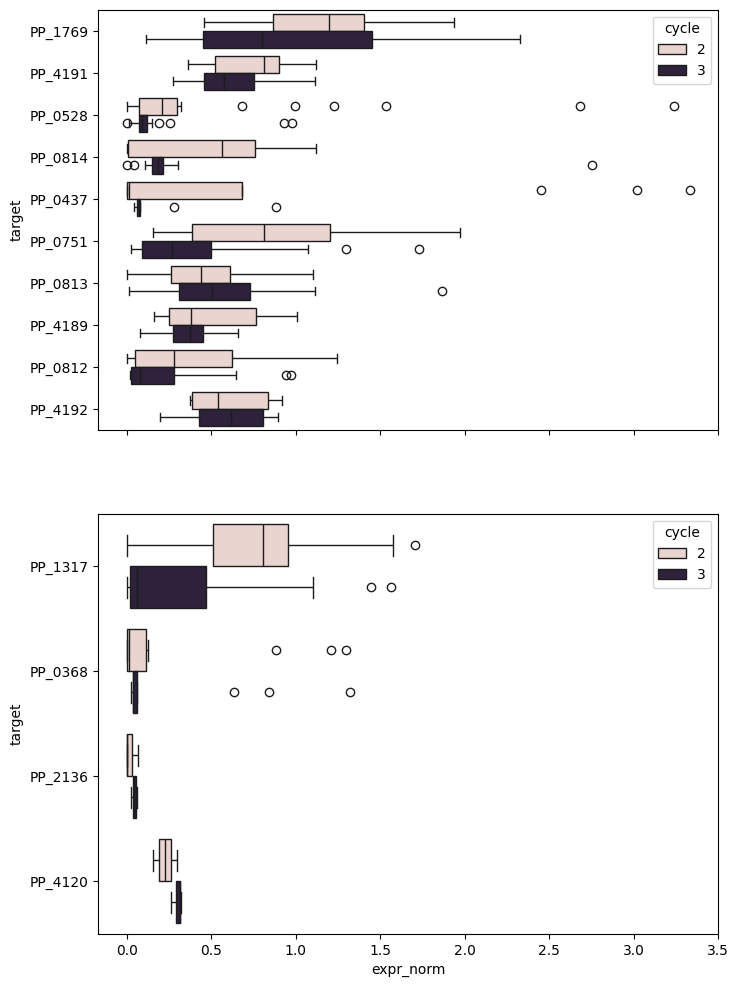

In [28]:
fig, ax = plt.subplots(2,1,figsize = (8,12), sharex = True)
sns.boxplot(data = target_downregulation_df[target_downregulation_df['rbtnseq_essential'] == True], y = 'target', x = 'expr_norm', hue = 'cycle', ax = ax[0])
sns.boxplot(data = target_downregulation_df[target_downregulation_df['rbtnseq_essential'] == False], y = 'target', x = 'expr_norm', hue = 'cycle', ax = ax[1])

<Axes: xlabel='cycle', ylabel='expr_norm'>

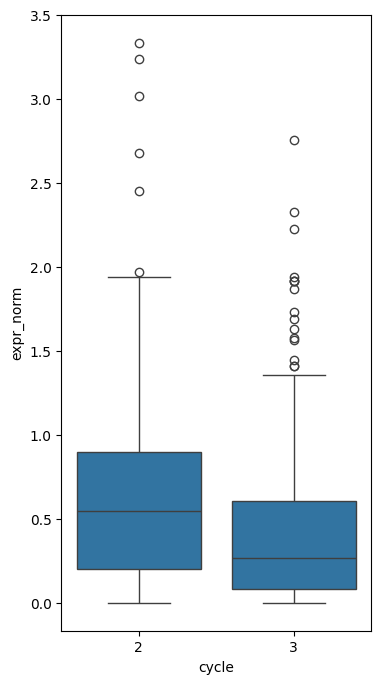

In [29]:
fig, ax = plt.subplots(1,1,figsize = (4,8))
sns.boxplot(data = target_downregulation_df, x = 'cycle', y = 'expr_norm')

## Compare dCas9/titer in each cycle 

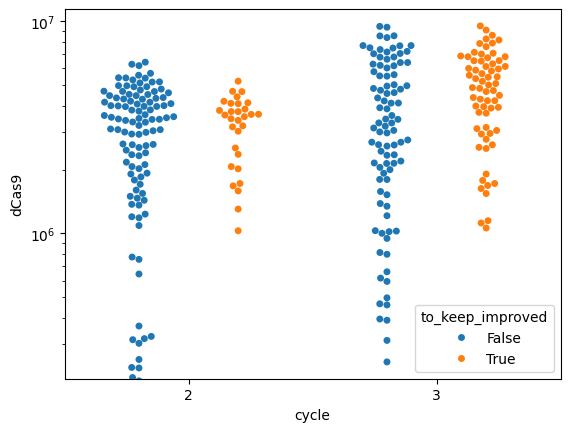

In [30]:
fig, ax = plt.subplots()
sns.swarmplot(data = df_merge, x = 'cycle', hue = 'to_keep_improved', y = 'dCas9', dodge = True)
ax.set_yscale('log')

In [31]:
df_merge

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,target_4_belowthresh,all_targets_belowthresh,all_reps_belowthresh,all_reps_above_dcas9_thresh,to_keep,to_keep_improved,cycle
0,PP_0528_PP_0815_PP_1317_PP_4191-R1,1,False,PP_0528_PP_0815_PP_1317_PP_4191,4,201.9179,49382.666,0.013451,PP_0528,PP_0815,...,False,True,False,False,False,False,False,False,False,2
1,PP_0528_PP_0813_PP_0815_PP_1317-R1,1,False,PP_0528_PP_0813_PP_0815_PP_1317,4,392.7469,4455954.600,1.213698,PP_0528,PP_0813,...,True,False,True,False,False,False,True,True,False,2
2,PP_0528_PP_0814_PP_0815_PP_1317-R1,1,False,PP_0528_PP_0814_PP_0815_PP_1317,4,457.0174,3443301.800,0.937875,PP_0528,PP_0814,...,True,False,True,False,False,False,True,True,False,2
3,PP_0528_PP_0813_PP_4191-R1,1,False,PP_0528_PP_0813_PP_4191,3,361.4189,3045374.950,0.829489,PP_0528,PP_0813,...,True,True,True,False,True,False,True,False,False,2
4,PP_0528_PP_0751_PP_4191-R1,1,False,PP_0528_PP_0751_PP_4191,3,321.5996,1846050.200,0.502821,PP_0528,PP_0751,...,True,True,False,False,False,False,True,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,PP_2136_PP_4189-R2,2,False,PP_2136_PP_4189,2,240.3060,2544410.460,0.611444,PP_2136,PP_4189,...,True,True,False,False,True,True,True,True,True,3
173,PP_2136_PP_4189-R3,3,False,PP_2136_PP_4189,2,279.3125,1682268.720,0.404264,PP_2136,PP_4189,...,True,True,False,False,True,True,True,True,True,3
177,PP_4189_PP_4192-R1,1,False,PP_4189_PP_4192,2,334.0468,1627920.300,0.391203,PP_4189,PP_4192,...,True,True,False,False,True,True,True,True,True,3
178,PP_4189_PP_4192-R2,2,False,PP_4189_PP_4192,2,309.2708,1718862.000,0.413057,PP_4189,PP_4192,...,True,True,False,False,True,True,True,True,True,3


<Axes: xlabel='cycle', ylabel='dCas9_normtocontrol'>

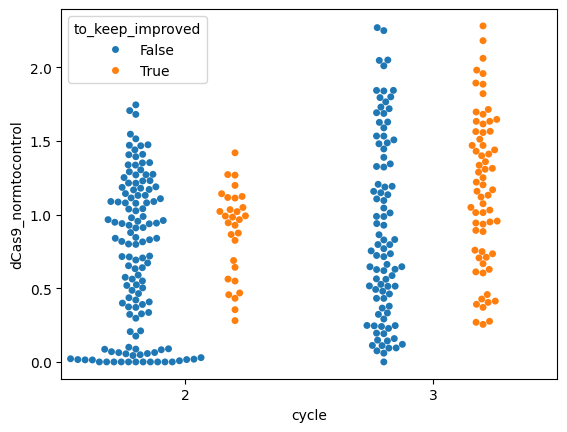

In [32]:
fig, ax = plt.subplots()
sns.swarmplot(data = df_merge, x = 'cycle', hue = 'to_keep_improved', y = 'dCas9_normtocontrol', dodge = True)

In [33]:
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

/tmp/ipykernel_11856/2343949401.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.swarmplot(data = df_merge, y = 'isoprenol', x = 'cycle',hue = 'cycle', dodge = True, ax = ax[0], palette=sns.color_palette())
/tmp/ipykernel_11856/2343949401.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_merge, y = 'isoprenol', x = 'cycle', dodge = True, ax = ax[1],palette=sns.color_palette())
/tmp/ipykernel_11856/2343949401.py:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data = df_merge, y = 'isoprenol', x = 'cycle', dodge = True, ax = ax[1],palette=sns.color_palette())


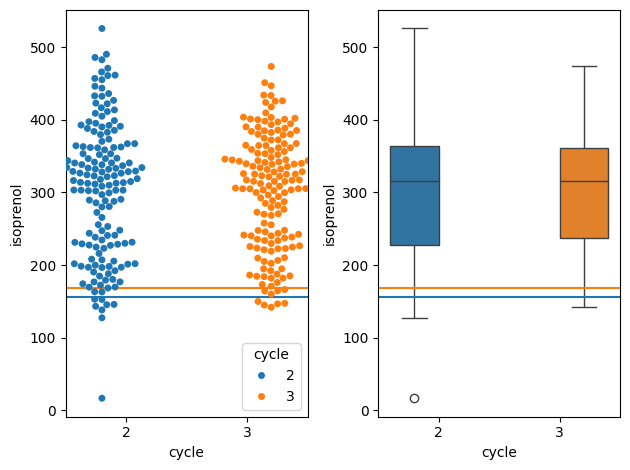

In [34]:
fig, ax = plt.subplots(ncols=2)
sns.swarmplot(data = df_merge, y = 'isoprenol', x = 'cycle',hue = 'cycle', dodge = True, ax = ax[0], palette=sns.color_palette())
sns.boxplot(data = df_merge, y = 'isoprenol', x = 'cycle', dodge = True, ax = ax[1],palette=sns.color_palette())
for a in ax:
    a.axhline(df_merge.loc[(df_merge['is_control']) & (df_merge['cycle'] == 2), 'isoprenol'].mean(), c = sns.color_palette()[0])
    a.axhline(df_merge.loc[(df_merge['is_control']) & (df_merge['cycle'] == 3), 'isoprenol'].mean(), c = sns.color_palette()[1])

plt.tight_layout()

Check that all of the strains match between cycle 2 and cycle 3

In [37]:
all(np.sort(df_merge.loc[df_merge['cycle'] == 2, 'Line Name'].unique()) == np.sort(df_merge.loc[df_merge['cycle'] == 3, 'Line Name'].unique()))

True

In [44]:
iso_df_c2 = df_merge.loc[
    (df_merge['cycle'] == 2),
    ['Line Name', 'line_name_norep', 'isoprenol']
].set_index('line_name_norep')
iso_df_c3 = df_merge.loc[
    (df_merge['cycle'] == 3),
    ['Line Name', 'line_name_norep', 'isoprenol']
].set_index('line_name_norep')

iso_df = pd.merge(
    left = iso_df_c2,
    right = iso_df_c3, 
    left_index=True,
    right_index=True,
    suffixes=('_c2', '_c3')
).reset_index()
iso_scatter_df = iso_df.melt(id_vars = 'line_name_norep', value_vars = ['isoprenol_c2', 'isoprenol_c3'])
iso_scatter_df

,line_name_norep,variable,value
0,PP_0528_PP_0815_PP_1317_PP_4191,isoprenol_c2,201.9179
1,PP_0528_PP_0815_PP_1317_PP_4191,isoprenol_c2,201.9179
2,PP_0528_PP_0815_PP_1317_PP_4191,isoprenol_c2,201.9179
3,PP_0528_PP_0813_PP_0815_PP_1317,isoprenol_c2,392.7469
4,PP_0528_PP_0813_PP_0815_PP_1317,isoprenol_c2,392.7469
...,...,...,...
1165,Control,isoprenol_c3,187.5493
1166,Control,isoprenol_c3,186.3067
1167,Control,isoprenol_c3,144.8960
1168,Control,isoprenol_c3,141.9620


In [48]:
iso_df_c2 = df_merge.loc[
    (df_merge['cycle'] == 2),
    ['line_name_norep', 'isoprenol']
].groupby('line_name_norep').mean()
iso_df_c3 = df_merge.loc[
    (df_merge['cycle'] == 3),
    ['line_name_norep', 'isoprenol']
].groupby('line_name_norep').mean()

iso_df = pd.merge(
    left = iso_df_c2,
    right = iso_df_c3, 
    left_index=True,
    right_index=True,
    suffixes=('_c2', '_c3')
).reset_index()
iso_df

,line_name_norep,isoprenol_c2,isoprenol_c3
0,Control,156.733342,168.831417
1,PP_0368_PP_0528_PP_4191,328.502033,337.627467
2,PP_0368_PP_0812,312.156633,364.611833
3,PP_0368_PP_0813,394.424700,355.079267
4,PP_0368_PP_1769,190.439533,241.181067
5,PP_0368_PP_4189,342.346733,335.353533
6,PP_0437_PP_0751_PP_4191,352.411767,234.237167
7,PP_0437_PP_0814,305.798300,306.253367
8,PP_0437_PP_1769,233.721367,183.288167
9,PP_0437_PP_4189,339.156567,290.934133


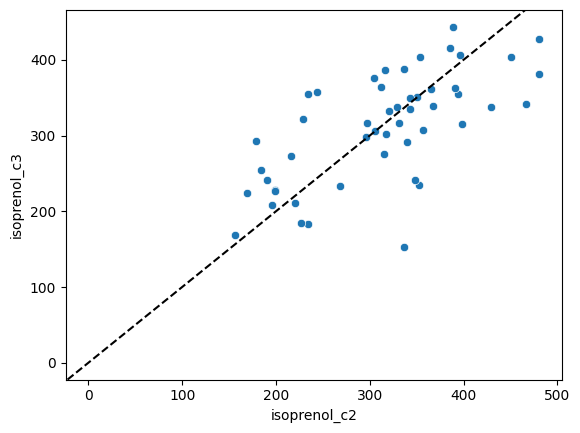

In [50]:
fig, ax = plt.subplots()
sns.scatterplot(data = iso_df, x = 'isoprenol_c2', y = 'isoprenol_c3') 
ax.axline((0,0), slope = 1, c= 'k', linestyle = '--')

In [39]:
cycle2_isoprenol_df

,Line Name,line_name_norep,isoprenol
0,PP_0528_PP_0815_PP_1317_PP_4191-R1,PP_0528_PP_0815_PP_1317_PP_4191,201.9179
1,PP_0528_PP_0813_PP_0815_PP_1317-R1,PP_0528_PP_0813_PP_0815_PP_1317,392.7469
2,PP_0528_PP_0814_PP_0815_PP_1317-R1,PP_0528_PP_0814_PP_0815_PP_1317,457.0174
3,PP_0528_PP_0813_PP_4191-R1,PP_0528_PP_0813_PP_4191,361.4189
4,PP_0528_PP_0751_PP_4191-R1,PP_0528_PP_0751_PP_4191,321.5996
...,...,...,...
184,PP_0437_PP_1769-R3,PP_0437_PP_1769,223.1004
185,PP_1769_PP_4192-R3,PP_1769_PP_4192,253.1558
186,PP_0368_PP_0812-R3,PP_0368_PP_0812,297.0306
187,PP_0815_PP_1317-R3,PP_0815_PP_1317,455.1851


In [36]:
filter_df = df_merge.melt(id_vars=['cycle', 'line_name_norep'], value_vars='to_keep_improved', value_name='To_keep').drop_duplicates()
filter_df

,cycle,line_name_norep,variable,To_keep
0,2,PP_0528_PP_0815_PP_1317_PP_4191,to_keep_improved,False
1,2,PP_0528_PP_0813_PP_0815_PP_1317,to_keep_improved,False
2,2,PP_0528_PP_0814_PP_0815_PP_1317,to_keep_improved,False
3,2,PP_0528_PP_0813_PP_4191,to_keep_improved,False
4,2,PP_0528_PP_0751_PP_4191,to_keep_improved,False
...,...,...,...,...
303,3,PP_1769_PP_2136,to_keep_improved,False
306,3,PP_1769_PP_4189,to_keep_improved,False
309,3,PP_1769_PP_4192,to_keep_improved,False
312,3,PP_2136_PP_4189,to_keep_improved,True


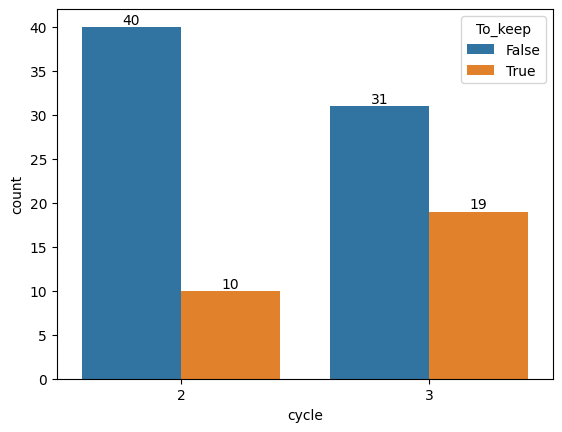

In [37]:
ax = sns.countplot(data = filter_df, x = 'cycle', hue = 'To_keep')
ax.bar_label(ax.containers[0], fontsize=10);
ax.bar_label(ax.containers[1], fontsize=10);

In [38]:
filter_df[filter_df['line_name_norep'] == 'PP_0528_PP_0815_PP_1317_PP_4191']

,cycle,line_name_norep,variable,To_keep
0,2,PP_0528_PP_0815_PP_1317_PP_4191,to_keep_improved,False
219,3,PP_0528_PP_0815_PP_1317_PP_4191,to_keep_improved,False


In [39]:
for cycle in [2, 3]:
    for ln in filter_df['line_name_norep'].unique():
        filter_df_idx = (filter_df['line_name_norep'] == ln) & (filter_df['cycle'] == cycle)
        all_same = len(filter_df.loc[filter_df_idx, 'To_keep'].unique()) == 1
        if not all_same:
            print(f'To_keep has different values for cycle: {cycle} line: {ln}')
            print(filter_df.loc[filter_df_idx, ['line_name_norep', 'To_keep']])

In [40]:
target_downregulation_df

,line_name_norep,cycle,position,target,expr_norm,rbtnseq_essential
347,PP_0815_PP_1317,2,1,PP_1317,0.000000,False
613,PP_0815_PP_1317_PP_4189,3,1,PP_1317,0.385501,False
108,PP_0751_PP_0815_PP_1317,2,2,PP_1317,1.195435,False
611,PP_0815_PP_1317_PP_4189,3,1,PP_1317,0.394267,False
110,PP_0814_PP_0815_PP_1317,2,2,PP_1317,0.841773,False
...,...,...,...,...,...,...
249,PP_0812_PP_0814,2,1,PP_0814,0.000000,True
250,PP_0814_PP_2136,2,0,PP_0814,0.008372,True
252,PP_0813_PP_1769,2,0,PP_0813,0.089891,True
243,PP_0812_PP_4189,2,1,PP_4189,0.387309,True


## Get some strains for David

In [41]:
df_dbtl3

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,target_4_belowthresh,all_targets_belowthresh,all_reps_belowthresh,all_reps_above_dcas9_thresh,to_keep,to_keep_improved,cycle
0,Control_P1-R1,1,True,Control,0,164.5141,5359855.90,1.288020,NaN,NaN,...,False,False,False,False,True,True,True,True,True,3
1,Control_P1-R2,2,True,Control,0,164.3461,4366543.06,1.049318,NaN,NaN,...,False,False,False,False,True,True,True,True,True,3
2,Control_P1-R3,3,True,Control,0,182.1113,5468736.89,1.314185,NaN,NaN,...,False,False,False,False,True,True,True,True,True,3
3,Control_P2-R1,1,True,Control,0,166.3666,1541613.50,0.370463,NaN,NaN,...,False,False,False,False,True,True,True,True,True,3
4,Control_P2-R2,2,True,Control,0,173.3588,4290673.00,1.031086,NaN,NaN,...,False,False,False,False,True,True,True,True,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,PP_0368_PP_4189_P4-R2,2,False,PP_0368_PP_4189_P4,2,213.9605,3926913.90,0.943671,PP_0368,PP_4189,...,False,False,False,False,False,False,True,False,False,3
176,PP_0368_PP_4189_P4-R3,3,False,PP_0368_PP_4189_P4,2,240.6646,3940017.58,0.946820,PP_0368,PP_4189,...,False,False,False,False,False,False,True,False,False,3
177,PP_4189_PP_4192-R1,1,False,PP_4189_PP_4192,2,334.0468,1627920.30,0.391203,PP_4189,PP_4192,...,True,True,False,False,True,True,True,True,True,3
178,PP_4189_PP_4192-R2,2,False,PP_4189_PP_4192,2,309.2708,1718862.00,0.413057,PP_4189,PP_4192,...,True,True,False,False,True,True,True,True,True,3


In [42]:
df_dcas9_target = df_dbtl3.copy()
column_idx_to_keep = np.concatenate([np.arange(0,24), np.array([34])])
df_dcas9_target = df_dcas9_target.iloc[:, column_idx_to_keep]
df_dcas9_target = df_dcas9_target[~df_dcas9_target['is_control']]
df_dcas9_target = df_dcas9_target.drop(columns=['is_control', 'Line Name', 'target_1', 'target_2', 'target_3', 'target_4'])
df_dcas9_target.head()

,rep,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1_value,target_2_value,target_3_value,target_4_value,target_1_control,target_2_control,target_3_control,target_4_control,target_1_norm,target_2_norm,target_3_norm,target_4_norm,to_keep_improved
12,1,PP_0368_PP_0528_PP_4191,3,338.7219,1148425.13,0.275976,189723.04,31351.38,7575668.69,NaN,2942120.455,4.663586e+05,2.538666e+07,NaN,0.064485,0.067226,0.298411,NaN,True
13,2,PP_0368_PP_0528_PP_4191,3,328.2770,3955120.40,0.950450,159803.80,67742.00,11667267.40,NaN,2942120.455,4.663586e+05,2.538666e+07,NaN,0.054316,0.145257,0.459583,NaN,True
14,3,PP_0368_PP_0528_PP_4191,3,345.8835,4659335.96,1.119679,91442.52,35170.20,12184926.46,NaN,2942120.455,4.663586e+05,2.538666e+07,NaN,0.031080,0.075414,0.479974,NaN,True
15,1,PP_0368_PP_0812,2,383.9056,6796940.86,1.633364,118473.94,712007.42,NaN,NaN,2942120.455,4.730152e+06,NaN,NaN,0.040268,0.150525,NaN,NaN,True
16,2,PP_0368_PP_0812,2,352.0482,6117201.50,1.470016,111106.45,424599.50,NaN,NaN,2942120.455,4.730152e+06,NaN,NaN,0.037764,0.089764,NaN,NaN,True


In [43]:
df_dcas9_target_grouped = df_dcas9_target.groupby(by = 'line_name_norep').mean()
target_cols = [f'target_{i}_norm' for i in [1,2,3,4]]
for n_grna in [2,3,4]:
    grna_index = df_dcas9_target_grouped['number_of_grna'] == n_grna
    df_dcas9_target_grouped.loc[grna_index, 'mean_downregulation'] = df_dcas9_target_grouped.loc[grna_index, target_cols[:n_grna]].mean(axis =1)
    df_dcas9_target_grouped.loc[grna_index, 'max_downregulation'] = df_dcas9_target_grouped.loc[grna_index, target_cols[:n_grna]].max(axis =1)

df_dcas9_target_grouped=df_dcas9_target_grouped.reset_index()
df_dcas9_target_grouped

,line_name_norep,rep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1_value,target_2_value,target_3_value,target_4_value,...,target_2_control,target_3_control,target_4_control,target_1_norm,target_2_norm,target_3_norm,target_4_norm,to_keep_improved,mean_downregulation,max_downregulation
0,PP_0368_PP_0528_PP_4191,2.0,3.0,337.627467,3.254294e+06,0.782035,1.469898e+05,4.475453e+04,1.047595e+07,NaN,...,4.663586e+05,2.538666e+07,NaN,0.049960,0.095966,0.412656,NaN,1.0,0.186194,0.412656
1,PP_0368_PP_0812,2.0,2.0,364.611833,6.474019e+06,1.555763,1.105141e+05,5.918727e+05,NaN,NaN,...,4.730152e+06,NaN,NaN,0.037563,0.125128,NaN,NaN,1.0,0.081345,0.125128
2,PP_0368_PP_0813,2.0,2.0,355.079267,5.900858e+06,1.418027,1.037222e+05,1.963546e+06,NaN,NaN,...,5.011360e+06,NaN,NaN,0.035254,0.391819,NaN,NaN,0.0,0.213537,0.391819
3,PP_0368_PP_1769,2.0,2.0,241.181067,5.756492e+05,0.138333,2.743372e+06,2.294248e+06,NaN,NaN,...,2.303088e+06,NaN,NaN,0.932447,0.996162,NaN,NaN,0.0,0.964305,0.996162
4,PP_0368_PP_4189,2.0,2.0,335.353533,4.526716e+06,1.087809,1.339013e+05,1.906545e+07,NaN,NaN,...,4.390577e+07,NaN,NaN,0.045512,0.434236,NaN,NaN,1.0,0.239874,0.434236
5,PP_0368_PP_4189_P4,2.0,2.0,225.418867,3.634413e+06,0.873381,1.872048e+06,3.681303e+07,NaN,NaN,...,4.390577e+07,NaN,NaN,0.636292,0.838455,NaN,NaN,0.0,0.737374,0.838455
6,PP_0437_PP_0751_PP_4191,2.0,3.0,234.237167,3.131306e+06,0.752480,1.450648e+04,2.867184e+06,1.637284e+07,NaN,...,1.383658e+07,2.538666e+07,NaN,0.062540,0.207218,0.644939,NaN,0.0,0.304899,0.644939
7,PP_0437_PP_0814,2.0,2.0,306.253367,8.095636e+06,1.945451,1.602306e+04,8.011530e+03,NaN,NaN,...,4.773578e+04,NaN,NaN,0.069078,0.167831,NaN,NaN,1.0,0.118454,0.167831
8,PP_0437_PP_1769,2.0,2.0,183.288167,8.446121e+05,0.202968,9.566600e+04,2.777520e+06,NaN,NaN,...,2.303088e+06,NaN,NaN,0.412432,1.205998,NaN,NaN,0.0,0.809215,1.205998
9,PP_0437_PP_4189,2.0,2.0,290.934133,3.918974e+06,0.941763,1.519379e+04,9.469674e+06,NaN,NaN,...,4.390577e+07,NaN,NaN,0.065503,0.215682,NaN,NaN,1.0,0.140592,0.215682


<Axes: xlabel='dCas9_normtocontrol', ylabel='mean_downregulation'>

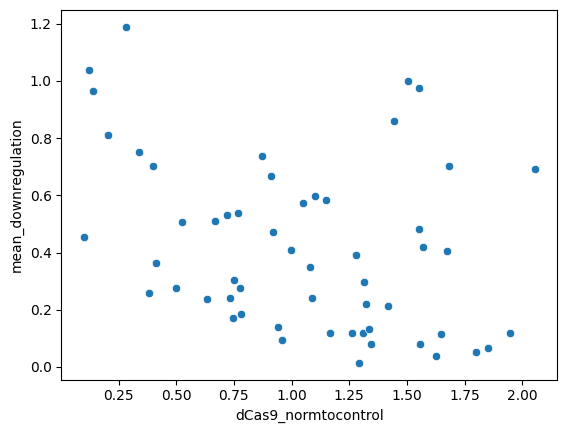

In [44]:
sns.scatterplot(data = df_dcas9_target_grouped, x = 'dCas9_normtocontrol', y = 'mean_downregulation')

In [45]:
%pip install adjustText
from adjustText import adjust_text


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Strains with good dCas9 expression but poor downregulation
PP_0368_PP_4189_P4
PP_0528_PP_0812_PP_4191
PP_0751_PP_0814_PP_1769
PP_0751_PP_0815_PP_1317
PP_1769_PP_4189


[None, None, None, None, None]

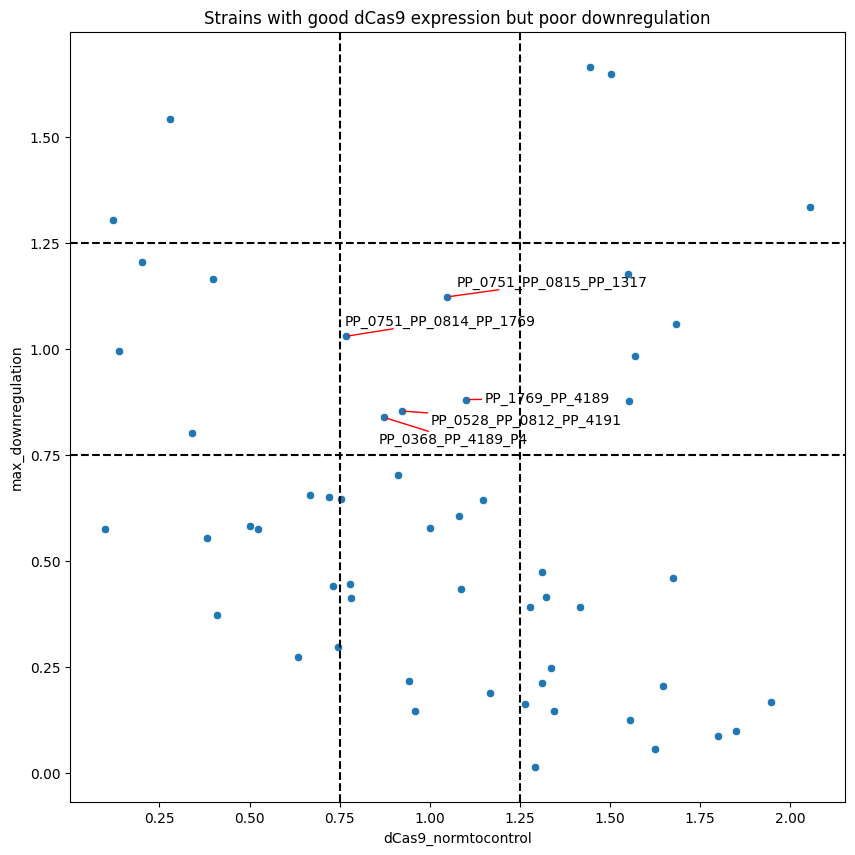

In [46]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = df_dcas9_target_grouped, x = 'dCas9_normtocontrol', y = 'max_downregulation')
def label_point(x, y, val, ax):
    texts = []
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        t = ax.text(point['x'], point['y'], str(point['val']))
        texts.append(t)
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))
    return texts
cas_thresh = [0.75, 1.25]
dr_thresh = [0.75, 1.25]
        
points_to_label = (
    (df_dcas9_target_grouped['dCas9_normtocontrol'] > cas_thresh[0]) & 
    (df_dcas9_target_grouped['dCas9_normtocontrol'] < cas_thresh[1]) & 
    (df_dcas9_target_grouped['max_downregulation'] > dr_thresh[0]) & 
    (df_dcas9_target_grouped['max_downregulation'] < dr_thresh[1])
)

lbls = label_point(x = df_dcas9_target_grouped.loc[points_to_label, 'dCas9_normtocontrol'],
            y = df_dcas9_target_grouped.loc[points_to_label, 'max_downregulation'],
            val = df_dcas9_target_grouped.loc[points_to_label, 'line_name_norep'],
            ax = ax)  

for t in cas_thresh:
    ax.axvline(t, c='k', linestyle = '--')
for t in dr_thresh:
    ax.axhline(t, c = 'k', linestyle = '--')
ax.set_title('Strains with good dCas9 expression but poor downregulation')

print('Strains with good dCas9 expression but poor downregulation')
[print(lbl.get_text()) for lbl in lbls]


Strains with poor dCas9 expression and normal-ish target downregulation as measured by the least effective gRNA
PP_0368_PP_1769
PP_0437_PP_1769
PP_0751_PP_0813_PP_4191
PP_0815_PP_1317_PP_4191


[None, None, None, None]

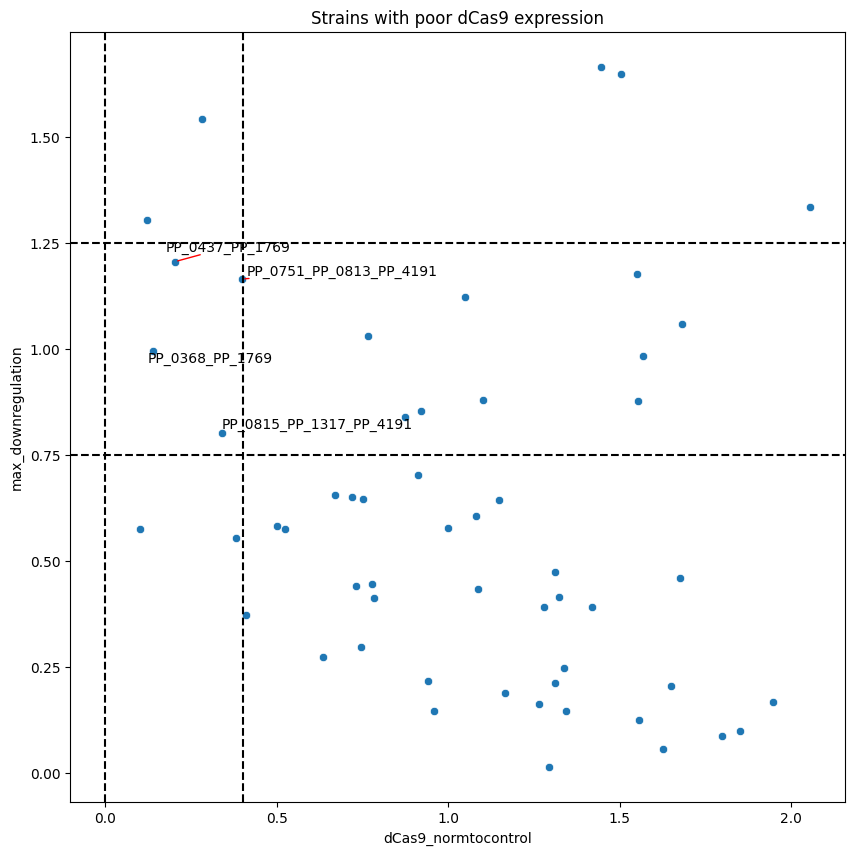

In [47]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = df_dcas9_target_grouped, x = 'dCas9_normtocontrol', y = 'max_downregulation')
 
cas_thresh = [0, 0.4]
dr_thresh = [0.75, 1.25]
        
points_to_label = (
    (df_dcas9_target_grouped['dCas9_normtocontrol'] > cas_thresh[0]) & 
    (df_dcas9_target_grouped['dCas9_normtocontrol'] < cas_thresh[1]) & 
    (df_dcas9_target_grouped['max_downregulation'] > dr_thresh[0]) & 
    (df_dcas9_target_grouped['max_downregulation'] < dr_thresh[1])
)

lbls = label_point(x = df_dcas9_target_grouped.loc[points_to_label, 'dCas9_normtocontrol'],
            y = df_dcas9_target_grouped.loc[points_to_label, 'max_downregulation'],
            val = df_dcas9_target_grouped.loc[points_to_label, 'line_name_norep'],
            ax = ax)  

for t in cas_thresh:
    ax.axvline(t, c='k', linestyle = '--')
for t in dr_thresh:
    ax.axhline(t, c = 'k', linestyle = '--')
ax.set_title('Strains with poor dCas9 expression')

print('Strains with poor dCas9 expression and normal-ish target downregulation as measured by the least effective gRNA')
[print(lbl.get_text()) for lbl in lbls]

Strains with poor dCas9 expression and normal-ish target downregulation as measured by the mean downregulation
PP_0368_PP_1769
PP_0437_PP_1769
PP_0528_PP_0815_PP_1317_PP_4191
PP_0751_PP_0813_PP_4191
PP_0815_PP_1317_PP_4191
PP_1769_PP_4192


[None, None, None, None, None, None]

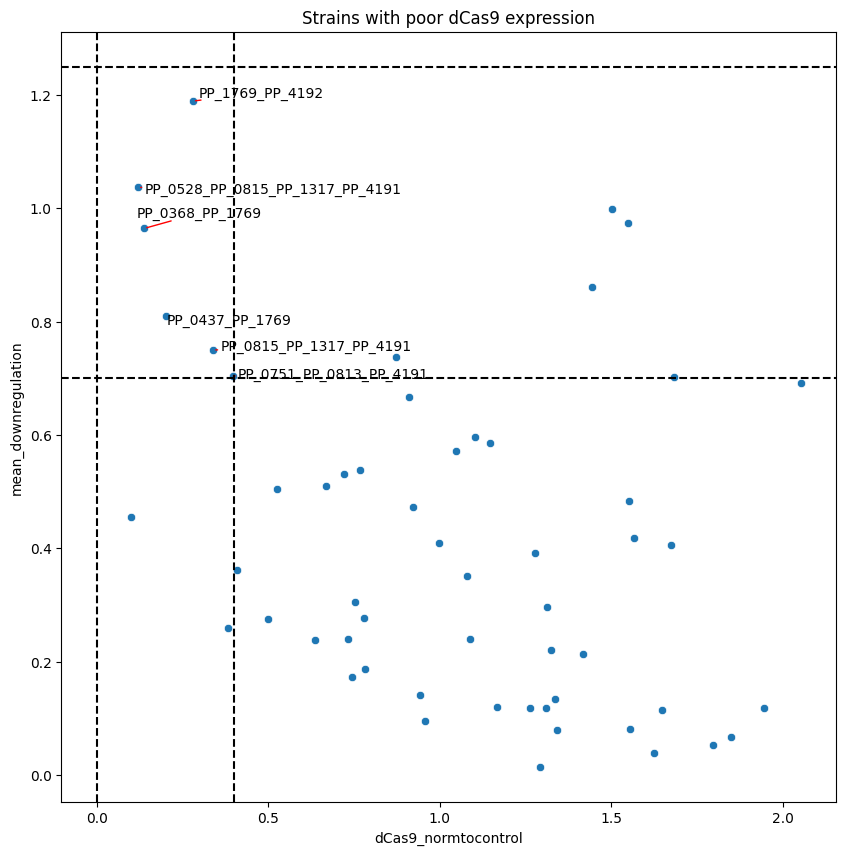

In [48]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = df_dcas9_target_grouped, x = 'dCas9_normtocontrol', y = 'mean_downregulation')
 
cas_thresh = [0, 0.4]
dr_thresh = [0.7, 1.25]
        
points_to_label = (
    (df_dcas9_target_grouped['dCas9_normtocontrol'] > cas_thresh[0]) & 
    (df_dcas9_target_grouped['dCas9_normtocontrol'] < cas_thresh[1]) & 
    (df_dcas9_target_grouped['mean_downregulation'] > dr_thresh[0]) & 
    (df_dcas9_target_grouped['mean_downregulation'] < dr_thresh[1])
)

lbls = label_point(x = df_dcas9_target_grouped.loc[points_to_label, 'dCas9_normtocontrol'],
            y = df_dcas9_target_grouped.loc[points_to_label, 'mean_downregulation'],
            val = df_dcas9_target_grouped.loc[points_to_label, 'line_name_norep'],
            ax = ax)  

for t in cas_thresh:
    ax.axvline(t, c='k', linestyle = '--')
for t in dr_thresh:
    ax.axhline(t, c = 'k', linestyle = '--')
ax.set_title('Strains with poor dCas9 expression')

print('Strains with poor dCas9 expression and normal-ish target downregulation as measured by the mean downregulation')
[print(lbl.get_text()) for lbl in lbls]

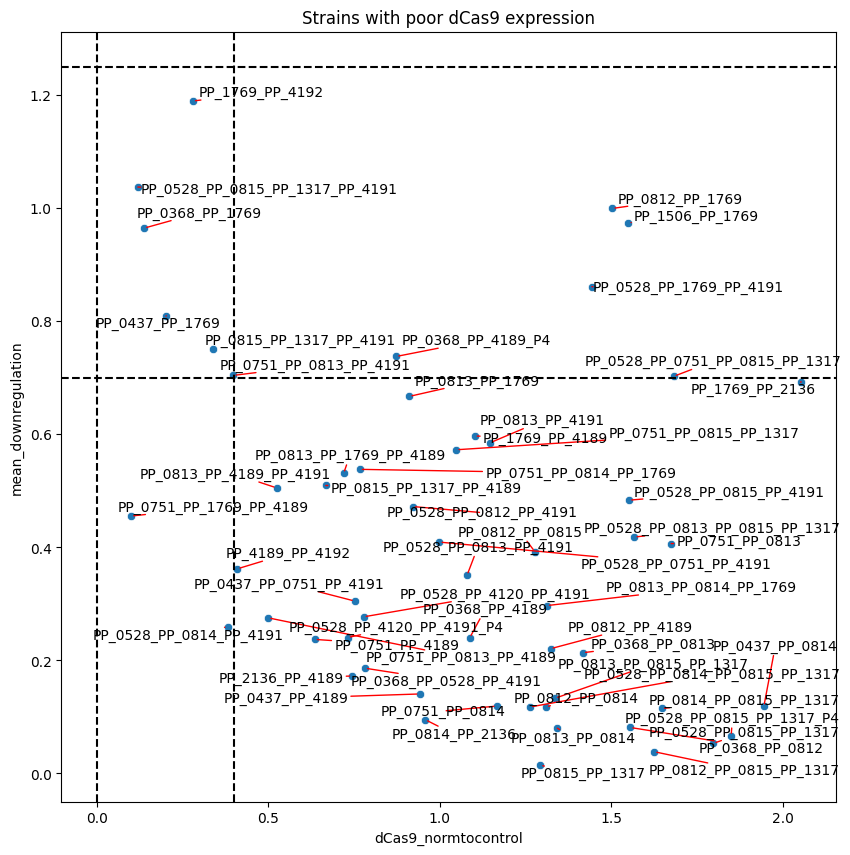

In [49]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = df_dcas9_target_grouped, x = 'dCas9_normtocontrol', y = 'mean_downregulation')
 
cas_thresh = [0, 5]
dr_thresh = [0, 5]
        
points_to_label = (
    (df_dcas9_target_grouped['dCas9_normtocontrol'] > cas_thresh[0]) & 
    (df_dcas9_target_grouped['dCas9_normtocontrol'] < cas_thresh[1]) & 
    (df_dcas9_target_grouped['mean_downregulation'] > dr_thresh[0]) & 
    (df_dcas9_target_grouped['mean_downregulation'] < dr_thresh[1])
)

lbls = label_point(x = df_dcas9_target_grouped.loc[points_to_label, 'dCas9_normtocontrol'],
            y = df_dcas9_target_grouped.loc[points_to_label, 'mean_downregulation'],
            val = df_dcas9_target_grouped.loc[points_to_label, 'line_name_norep'],
            ax = ax)  
cas_thresh = [0, 0.4]
dr_thresh = [0.7, 1.25]
for t in cas_thresh:
    ax.axvline(t, c='k', linestyle = '--')
for t in dr_thresh:
    ax.axhline(t, c = 'k', linestyle = '--')
ax.set_title('Strains with poor dCas9 expression')
fig.savefig('strains_with_poor_dcas9_expr.svg')

In [50]:
df_dcas9_target_grouped.to_csv('df_to_pick_sequencing_targets.csv')